In [1]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
print ('Data loaded')

Data loaded


In [2]:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of valid examples=", X_valid.shape[0])
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of valid examples= 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
### Data exploration visualization
import matplotlib.pyplot as plt
import csv

%matplotlib inline
figsize_default = plt.rcParams['figure.figsize']

In [5]:
# maps from class index into human readable text
signname = {}
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for r in reader:
        if r[0].isdigit():
            signname[int(r[0])] = r[1]
NCLASS = len(signname)

In [6]:
def view(img, label=None):
    """plot the image (RGB or gray)"""
    if label:
        print(signname[label])
    if len(img.shape) == 3 and img.shape[2] == 3:
        plt.imshow(img)
    else:
        plt.imshow(img.squeeze(), cmap='gray')

In [7]:
def samples_stat(features, labels):
    """return the histogram of labels and a map mapping from label to one image"""
    h = [0 for i in range(NCLASS)]
    samples = {}
    for idx, l in enumerate(labels):
        h[l] += 1
        if l not in samples:
            samples[l] = features[idx]
    return h, samples

In [8]:
###plot images with stat
def explore(features, labels):
    "Functions to explore the given data set"
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    histo, samples = samples_stat(features, labels)
    total_class = len(set(labels))
    ncols = 4
    nrows = 11

    print("total tests {}. total labels: {}".format(len(features), total_class))
    _, axes = plt.subplots(nrows=nrows, ncols=ncols)

    class_idx = 0
    for r in range(nrows):
        for c in range(ncols):
            a = axes[r][c]
            a.axis('off')
            if class_idx in samples:
                a.imshow(samples[class_idx])
            if class_idx in signname:
                a.set_title("No.{} {}(#{})".format(class_idx, signname[class_idx], histo[class_idx]), fontsize=12)
            class_idx += 1
    plt.rcParams['figure.figsize'] = figsize_default

total tests 34799. total labels: 43


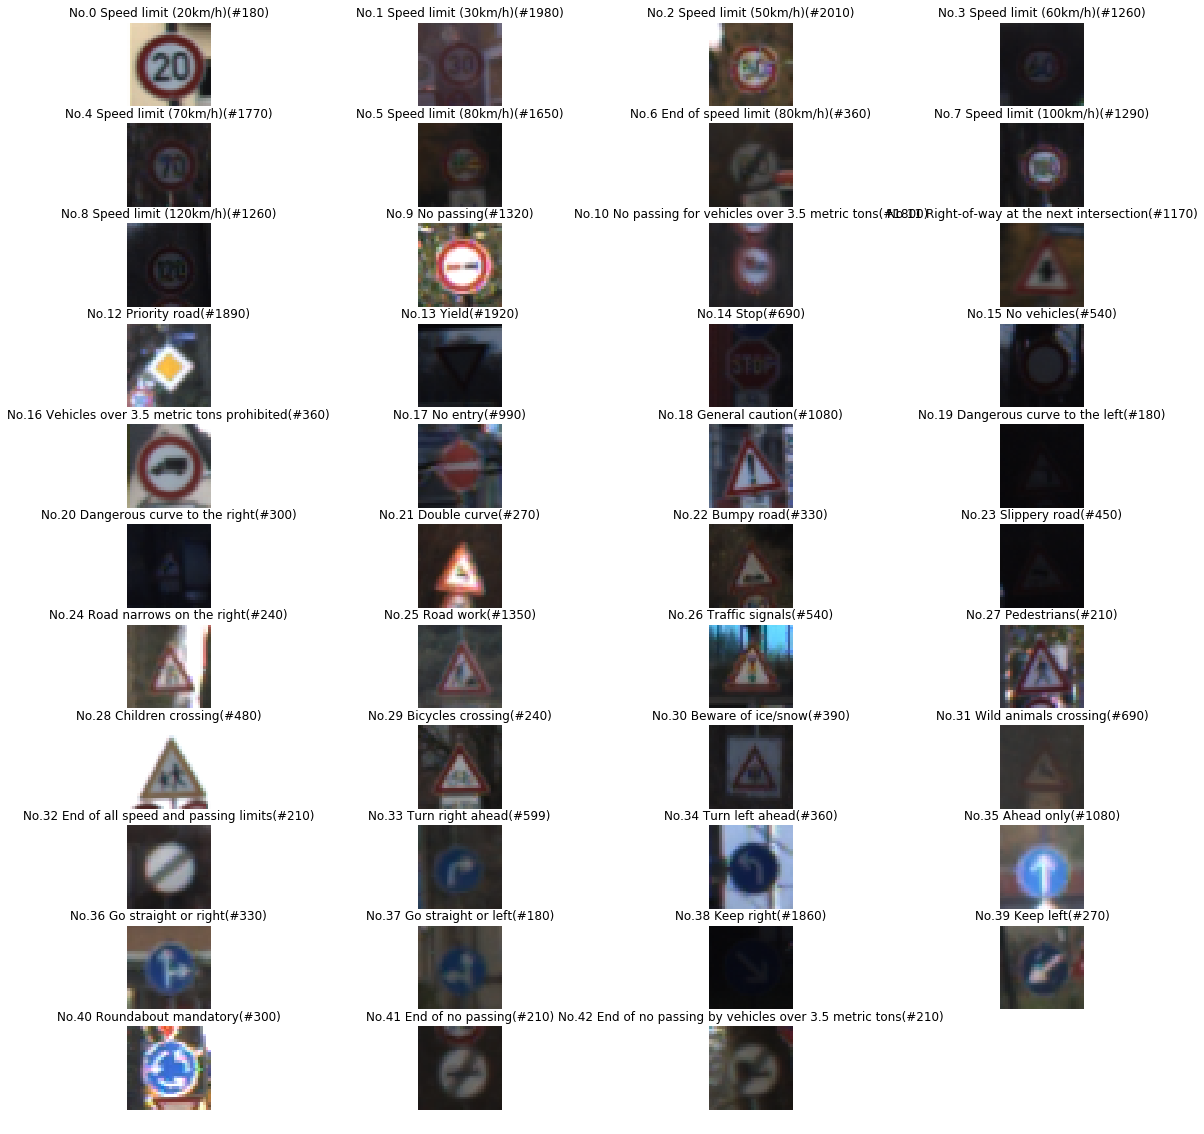

In [9]:
explore(X_train, y_train)

In [10]:
### Preprocess images: normalize images from [0,255] to [0,1], and gray scale it
### Rationale: although colors in the traffic sign are important in real world for people to recoganize
###            different signs, traffic signs are also different in their shapes and contents. We can
###            ignore colors in this problem because signs in our training set are differentiable from
###            their contents and shapes.
import numpy as np
import cv2

def reshape_raw_images(imgs):
    """Given 4D images (number, heigh, weight, channel), this
    function grayscales and returns (number, height, weight, 1) images"""
    def gray(src):
        if src.dtype == np.uint8:
            src = np.array(src/255.0, dtype=np.float32)
        dst = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
        return dst.reshape(32,32,1)
    norms = [gray(img) for img in imgs]
    return np.array(norms)
    
features_train = reshape_raw_images(X_train)
labels_train   = y_train

features_valid = reshape_raw_images(X_valid)
labels_valid   = y_valid

features_test  = reshape_raw_images(X_test)
labels_test    = y_test

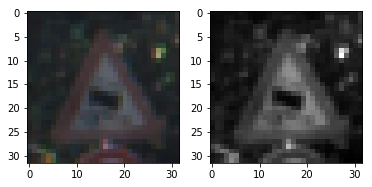

In [11]:
_, vframes = plt.subplots(nrows=1, ncols=2)
vframes[0].imshow(X_train[2000])
vframes[1].imshow(features_train[2000].squeeze(), cmap='gray')

In [12]:
### Architecture:
###   I adapted LeNet architecture: Two convolutional layers followed by one flatten layer and three
###   fully connected linear layers.
###
###   convolution 1: 32x32x1  -> 28x28x12 -> relu -> 14x14x12 (pooling)
###   convolution 2: 14x14x12 -> 10x10x25 -> relu -> 5x5x25   (pooling)
###         flatten: 5x5x25   -> 625
###        drop out: 625      -> 625
###          linear: 625      -> 300
###          linear: 300      -> 150
###          linear: 150      -> 43

### Experiment shows that
### 1. drop out has positive impact on the accuracy
### 2. longer depth (to some extent) on convolution filter has better accuracy

import tensorflow as tf

mu, sigma = 0, 0.1

def conv(input, in_len, in_depth, out_len, out_depth):
    """ Define a convolutional network layer
    @param input: input data or model
    @param in_len: 0D, the input height and width (assume they're the same)
    @param in_depth: 0D, the input depth (e.g. 3 for RGB images)
    @param out_len: 0D, desired output height and width
    @param out_depth: 0D, desired output depth
    """
    filter_len = in_len - out_len + 1
    # we're not going to use stride to reduce the dimention,
    # we're going to use pooling instead.
    strides = [1,1,1,1]

    W = tf.Variable(tf.truncated_normal(shape=(filter_len, filter_len, in_depth, out_depth), \
                                        mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(out_depth))
    model = tf.nn.conv2d(input, W, strides=strides, padding='VALID') + b
    return model

def linear(input, in_size, out_size):
    W = tf.Variable(tf.truncated_normal(shape=(in_size, out_size), \
                                        mean=mu, stddev = sigma))
    b = tf.Variable(tf.zeros(out_size))
    model = tf.matmul(input, W) + b
    return model
    
def classifier(input, keep_prob):
    ## Layer1
    # convolution layer: 32x32x1 -> 28x28x12
    conv1 = conv(input, 32, 1, 28, 12)
    conv1 = tf.nn.relu(conv1)
    # pooling: 28x28x12 -> 14x14x12
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    ## Layer2
    # convolution layer 14x14x12 -> 10x10x25
    conv2 = conv(conv1, 14, 12, 10, 25)
    conv2 = tf.nn.relu(conv2)
    # pooling: 10x10x25 -> 5x5x25
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    ## Layer3
    # -> 625
    flat = tf.contrib.layers.flatten(conv2)
    dropped = tf.nn.dropout(flat, keep_prob)
    layer3 = linear(dropped, 625, 300)
    layer3 = tf.nn.relu(layer3)
    
    ## Layer4
    layer4 = linear(layer3, 300, 100)
    layer4 = tf.nn.relu(layer4)
    
    ## Layer 5
    layer5 = linear(layer4, 100, n_classes)
    return layer5
    

C:\Users\Lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: P

In [13]:
### Define the model and its input

from sklearn.utils import shuffle

feature_shape = features_train.shape[1:]
x = tf.placeholder(tf.float32, shape=(None,)+feature_shape)
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
# drop out layer parameter. This parameter should be 1.0 when evaluate and test
# the model, less than 1.0 when training
keep_prob = tf.placeholder(tf.float32)

logits = classifier(x, keep_prob)

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
# A function for evaluating the accuracy of a model
prediction_step = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuary_step = tf.reduce_mean(tf.cast(prediction_step, tf.float32))
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuary_step, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [15]:
import time

saver = tf.train.Saver()
model_file = './model'

In [16]:
### training
### Training the model use adam optimizer to minimize the cross entropy (loss)
from sklearn.model_selection import train_test_split

# Define training parameters
epoch = 10
batch_size = 64
rate = 0.001

# Training pipepline
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss = tf.reduce_mean(cross_entropy)
train_step  = tf.train.AdamOptimizer(learning_rate=rate).minimize(loss)

# Starts training
def train(X_data, y_data):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print("starting ...")
        for i in range(epoch):
            X_train, X_tst, y_train, y_tst = train_test_split(X_data, y_data, test_size=0.1, random_state=int(time.time()))
            begin_time = time.time()
            for offset in range(0, len(X_train), batch_size):
                end = offset + batch_size
                features, labels = X_train[offset:end], y_train[offset:end]
                sess.run(train_step, feed_dict={x : features, y : labels, keep_prob: 0.8})
            validation = evaluate(X_tst, y_tst)
            print("[{3:.1f}s] epoch {0}/{1}: validation = {2:.3f}".format(i+1, epoch, validation, time.time()-begin_time))

        saver.save(sess, model_file);
        print("model saved into {}".format(model_file))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [17]:
# train
train(features_train, labels_train)


starting ...
[29.2s] epoch 1/10: validation = 0.894
[28.5s] epoch 2/10: validation = 0.954
[28.5s] epoch 3/10: validation = 0.960
[28.6s] epoch 4/10: validation = 0.979
[28.5s] epoch 5/10: validation = 0.990
[29.7s] epoch 6/10: validation = 0.988
[28.4s] epoch 7/10: validation = 0.992
[29.8s] epoch 8/10: validation = 0.995
[29.7s] epoch 9/10: validation = 0.994
[29.5s] epoch 10/10: validation = 0.996
model saved into ./model


In [18]:
# evaluate the validate set
with tf.Session() as sess:
    saver.restore(sess, model_file)
    acc = evaluate(features_valid, labels_valid)
    print("accuracy in validation set: {:.3f}".format(acc))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model
accuracy in validation set: 0.924


In [19]:
# test
with tf.Session() as sess:
    saver.restore(sess, model_file)
    acc = evaluate(features_test, labels_test)
    print("accuracy in test set: ", acc)

INFO:tensorflow:Restoring parameters from ./model
accuracy in test set:  0.9282660332447182


In [21]:
### Images are found on Wikipedia. All images are clean and noise-free.
### The classifier is expected to behave correctly on most of them.

### Some interesting notes:
### I want to see how the classifier performs for similar signs
###   the General Caution and Traffic signals: they look a vertical bar (see below)
###   Pedestrains and Child crossing
###   Pedestrains and Wild animals crossing
from PIL import Image
import os

def read_file_to_32x32_array(file):
    x = Image.open(file).convert("RGB")
    x = x.resize((32,32))
    return np.array(x)

folder = "mydata"
files = [f for f in os.listdir(folder) if f.endswith("png") or f.endswith("jpg")]
paths = [os.path.join(folder, f) for f in files]
my_labels = [int(f.split('.')[0]) for f in files]

my_images = np.array([read_file_to_32x32_array(f) for f in paths])

total tests 11. total labels: 11


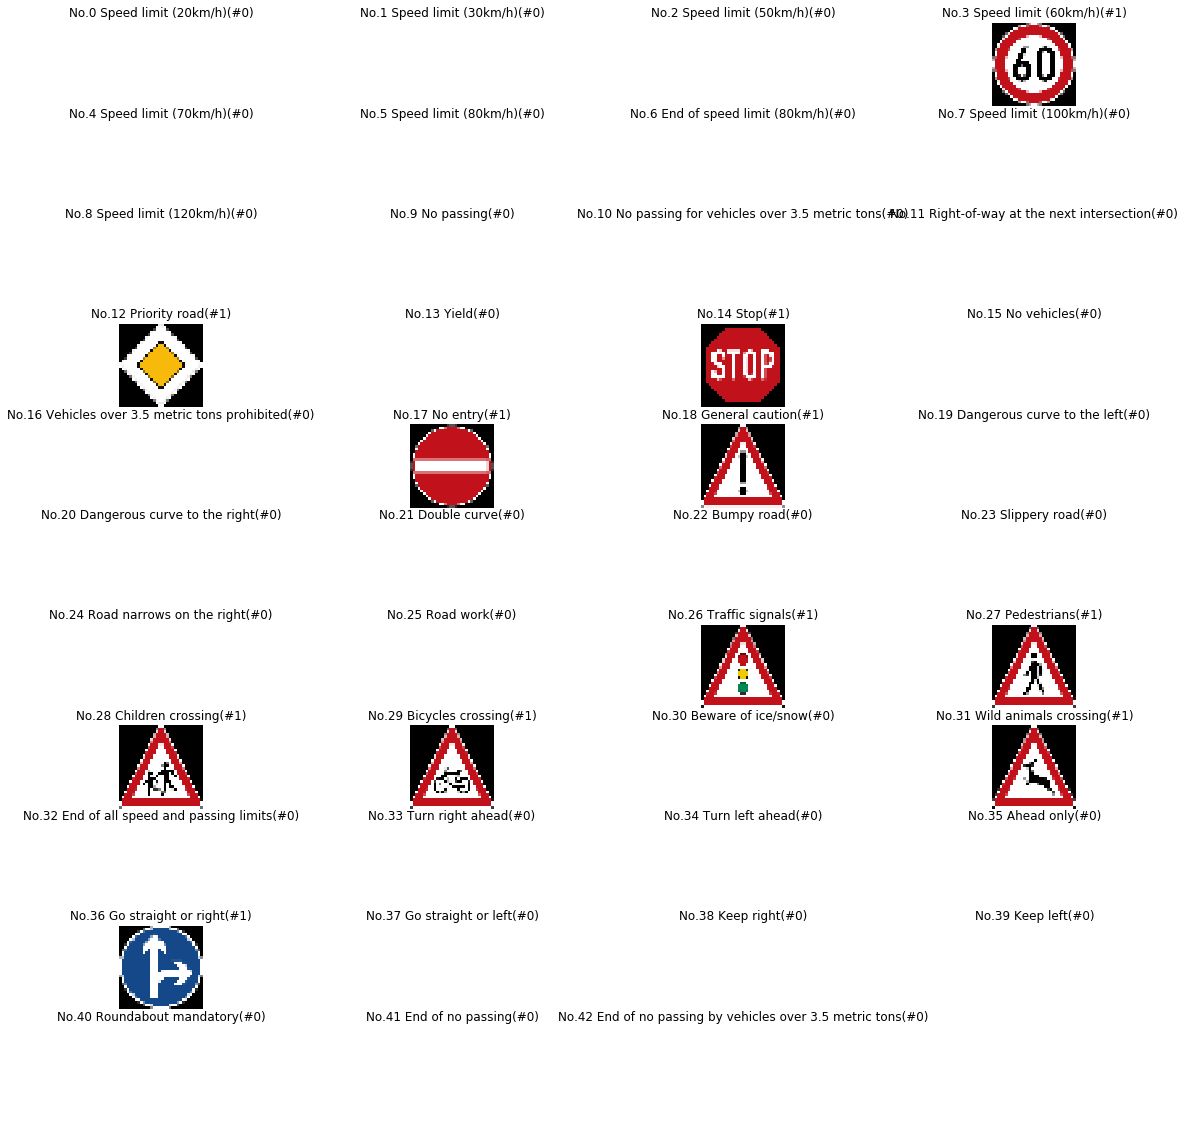

In [22]:
explore(my_images, my_labels)

In [23]:
# preprocess images
my_features = reshape_raw_images(my_images)

# Here is a function to predict images and output human readable sign names
def predict(features, human_readable=False):
    with tf.Session() as sess:
        saver.restore(sess, model_file)
        results = sess.run(tf.argmax(logits, 1), {x : features, keep_prob:1.0})
        if human_readable:
            results = [signname[n] for n in results]
        return results

In [24]:
predict(my_features, True)

INFO:tensorflow:Restoring parameters from ./model


['Priority road',
 'Stop',
 'No entry',
 'General caution',
 'Traffic signals',
 'Right-of-way at the next intersection',
 'Children crossing',
 'Slippery road',
 'Speed limit (50km/h)',
 'Wild animals crossing',
 'Go straight or right']

In [25]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, model_file)
    acc = evaluate(my_features, my_labels)
    print("accuracy is {:.3f}".format(acc))

INFO:tensorflow:Restoring parameters from ./model
accuracy is 0.727


In [26]:
def prediction_in_detail(features):
    with tf.Session() as sess:
        saver.restore(sess, model_file)
        pred = tf.nn.softmax(logits)
        results = sess.run(tf.nn.top_k(pred, k=5), {x : features, keep_prob:1.0})
        return results

In [27]:
pd = prediction_in_detail(my_features)

INFO:tensorflow:Restoring parameters from ./model


In [28]:
def samples_stat(features, labels):
    h = [0 for i in range(NCLASS)]
    samples = {}
    for idx, l in enumerate(labels):
        h[l] += 1
        if l not in samples:
            samples[l] = features[idx]
    return h, samples
_, training_samples = samples_stat(X_train, y_train)
training_readable_labels = signname

In [29]:
def explore_topkv(features, topkv):
    "Functions to explore the given data set"
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    ncols = len(topkv.values[0])+1
    nrows = len(topkv.values)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols)
    
    for r, img in enumerate(features):
        # no axis
        for c in range(ncols):
            axes[r][c].axis('off')
        # show the given image
        cur = axes[r][0]
        cur.imshow(img)
        cur.set_title("The given image")
        # show the top five softmax prob
        for c,prob in enumerate(topkv.values[r]):
            cur = axes[r][c+1]
            class_idx = topkv.indices[r][c]
            sample = training_samples[class_idx]
            sample_text = training_readable_labels[class_idx]
            cur.imshow(sample)
            cur.set_title("{} ({:.2f})".format(sample_text, prob))
    plt.rcParams['figure.figsize'] = figsize_default

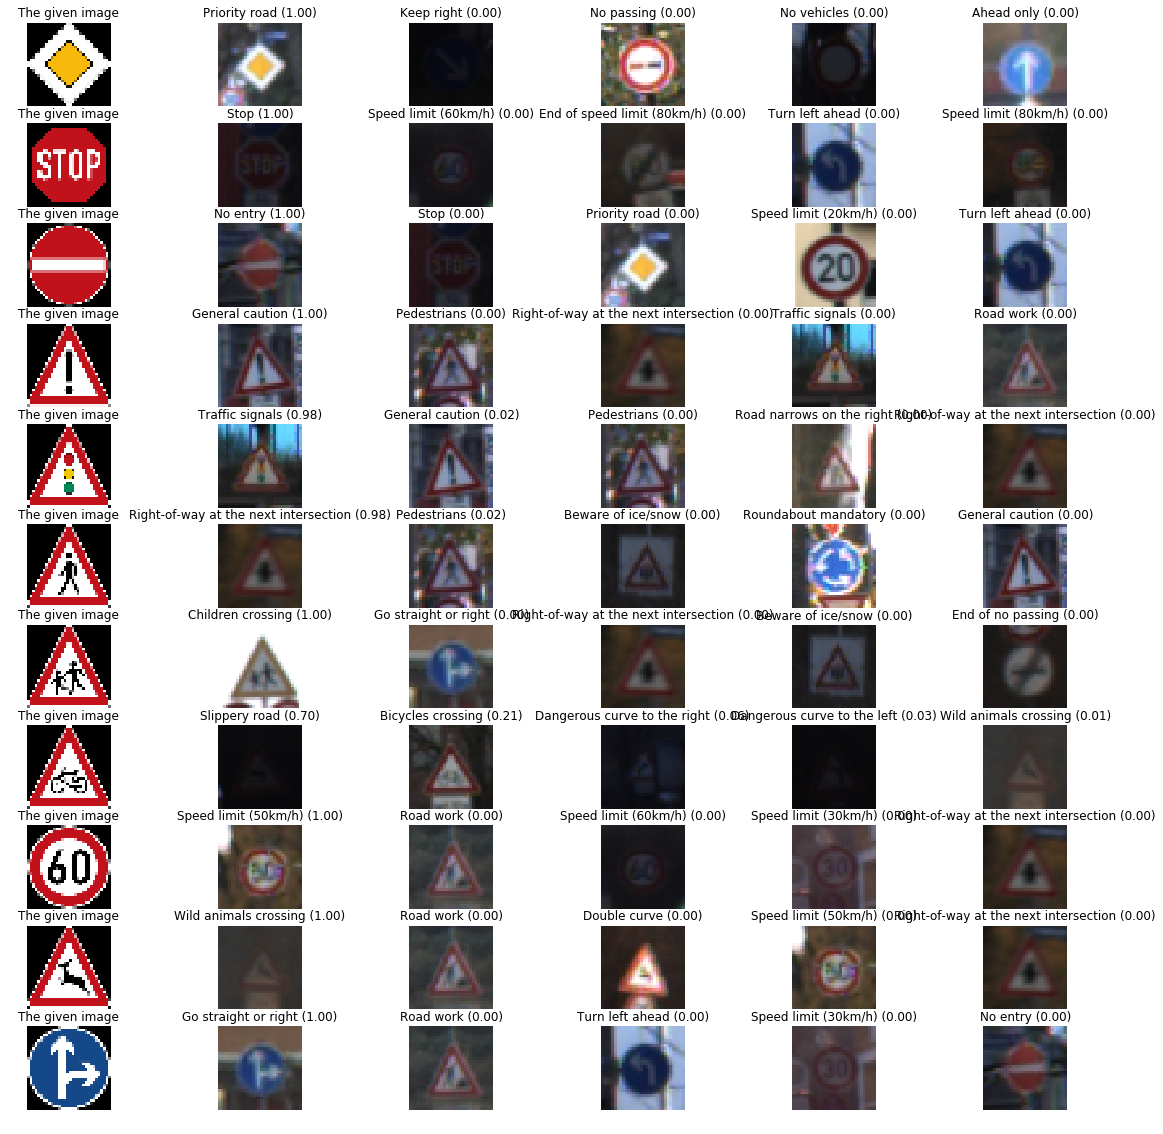

In [30]:
explore_topkv(my_images, pd)